[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ferit-osirv/lab7/blob/main/lab7.ipynb)


## Lab 7: Introduction to Medical Image Processing

The primary objective of this assignment is to measure the width of a person’s spleen using CT images to determine if they have **splenomegaly**, a condition where the spleen is abnormally enlarged.

### Background:

![Anatomical-Planes-and-Axes.jpg](https://marinbenc.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff636e5c1-42c8-49e7-9cc3-e812a7ed4e8b%2Fd4cae84a-7df6-43f2-8ec1-30cf6e67eeb6%2FAnatomical-Planes-and-Axes.jpg?table=block&id=1814daba-200a-800f-a6fc-e55eacb0e6ee&spaceId=f636e5c1-42c8-49e7-9cc3-e812a7ed4e8b&width=1420&userId=&cache=v2)

![Schematic-diagram-showing-the-method-for-measuring-splenic-length-width-and-depth-in.png](https://marinbenc.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff636e5c1-42c8-49e7-9cc3-e812a7ed4e8b%2Fb73c6a09-930a-4343-98b5-37ba805680ca%2FSchematic-diagram-showing-the-method-for-measuring-splenic-length-width-and-depth-in.png?table=block&id=1814daba-200a-8057-bd38-d3c00e0c2727&spaceId=f636e5c1-42c8-49e7-9cc3-e812a7ed4e8b&width=1420&userId=&cache=v2)

Splenomegaly can indicate various underlying conditions, including infections, liver disease, or blood disorders. Accurate measurement of spleen size is essential in clinical practice to diagnose and monitor these conditions. In this assignment, we will specifically focus on measuring the **maximum anterior-posterior (AP) width** of the spleen on transverse CT slices. This is the longest distance between the anterior (front) and posterior (back) parts of the spleen in a given transverse (parallel to the floor when standing) slice. See the photos above for an explanation of these terms (spleen width is labeled as “Width” on the transverse plane image).

![Screenshot 2025-01-20 at 11.47.35.png](https://marinbenc.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff636e5c1-42c8-49e7-9cc3-e812a7ed4e8b%2Fdaec3bd4-5324-4349-ac1a-36351bdb4f13%2FScreenshot_2025-01-20_at_11.47.35.png?table=block&id=1814daba-200a-8067-8c13-cf2b7cc4cda3&spaceId=f636e5c1-42c8-49e7-9cc3-e812a7ed4e8b&width=1420&userId=&cache=v2)

### Medical Imaging:

Medical images like **CT (Computed Tomography)**, **MRI (Magnetic Resonance Imaging)**, and **X-rays** provide detailed insights into the human body. CT images, in particular, are widely used in diagnosing conditions involving internal organs. These images are essentially 3D scans reconstructed into slices, which are 2D cross-sectional views of the body.

### What are Voxel-Based Images?

Unlike regular 2D images made up of pixels, CT images are **voxel-based**. A voxel (volumetric pixel) represents a 3D volume of space, capturing more detailed spatial information. Each CT scan is a 3D array of voxels, often represented as a **NumPy array** in Python, where the dimensions correspond to the axial (X), coronal (Y), and sagittal (Z) planes.

For example:

- A CT image might have a shape of `(512, 512, 100)`, where:
    - `512 x 512` corresponds to the width and height of each 2D slice.
    - `100` represents the number of slices along the Z-axis (depth).

### Voxel Size:

Each voxel has a physical size in millimeters, known as **voxel spacing**. This size determines the real-world dimensions represented by each voxel. The voxel size is typically provided in the CT scan metadata as `[row_spacing, col_spacing, slice_thickness]`. For example:

- A voxel size of `[0.78125, 0.78125, 3.0]` means:
    - Each pixel represents `0.78125 mm` in the axial plane (X-Y).
    - The distance between slices is `3.0 mm`.

Accurately interpreting voxel sizes is critical for converting measurements (e.g., spleen width) from pixels to real-world units (millimeters).

## Prerequisites

### Dataset

The Spleen Dataset from the Medical Segmentation Decathlon (MSD) is a benchmark dataset designed for the development and evaluation of medical image segmentation algorithms. It consists of 3D CT scans of the abdomen, focusing on the spleen. The dataset includes both imaging data and corresponding ground truth segmentation masks, where the spleen is labeled for each slice in the scans.

- Target: Spleen
- Modality: CT
- Size: 61 3D volumes (41 Training + 20 Testing)
- Source: Memorial Sloan Kettering Cancer Center, http://medicaldecathlon.com

Download and extract the dataset by running the following two code blocks (it might take a few minutes).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2 as cv

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE/view?usp=share_link' -O batch1.tar

In [ ]:
!tar -xvf batch1.tar

Take a look at the sidebar to see the downloaded files.

The files in the Spleen Dataset are provided in the **NIfTI (Neuroimaging Informatics Technology Initiative) format**, which is a commonly used file format for storing medical imaging data. NIfTI files are designed to handle multi-dimensional image data, such as 3D and 4D volumes, making them ideal for CT, MRI, and similar imaging modalities. 

Each NIfTI file contains a 3D volumetric image represented as a grid of voxels (3D pixels), along with metadata stored in the file's header. 

The metadata includes important information such as voxel dimensions (spacing), image orientation, and the affine transformation matrix, which maps voxel coordinates to real-world spatial coordinates. We can use the **nibabel** Python library to load and work with NIfTI files.

> ### Assignment 1: Load and Visualize a NIfTI File
> 1. Use the provided `load_ct_scan` function to load a CT scan and its corresponding label image from the dataset.
> 2. Investigate the shape of the data to understand how the slices are organized.
> 3. Select a transverse slice (e.g., the 35th slice) and display it using a suitable library.
> 4. Display the corresponding label slice where the spleen is marked (label `1`) and the rest is background (label `0`).
> 5. Create an image where the label is shown as a contour overlaid on the CT slice. Use OpenCV to extract and display the contours. The output should look like the following image (note that the example is cropped for display purposes).
>
> ![Screenshot 2025-01-20 at 09.46.35.png](https://marinbenc.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff636e5c1-42c8-49e7-9cc3-e812a7ed4e8b%2Fe198d6c7-0b61-4522-903f-519399785c4c%2FScreenshot_2025-01-20_at_09.46.35.png?table=block&id=1814daba-200a-80d6-ace8-f83233b175fe&spaceId=f636e5c1-42c8-49e7-9cc3-e812a7ed4e8b&width=570&userId=&cache=v2)

In [8]:
def load_ct_scan(file):
  ct_scan = nib.load(file)
  ct_data = ct_scan.get_fdata()
  ct_data = np.rot90(np.array(ct_data), k=-1)
  return ct_data

CT scan shape: (512, 512, 90)
Label image shape: (512, 512, 90)


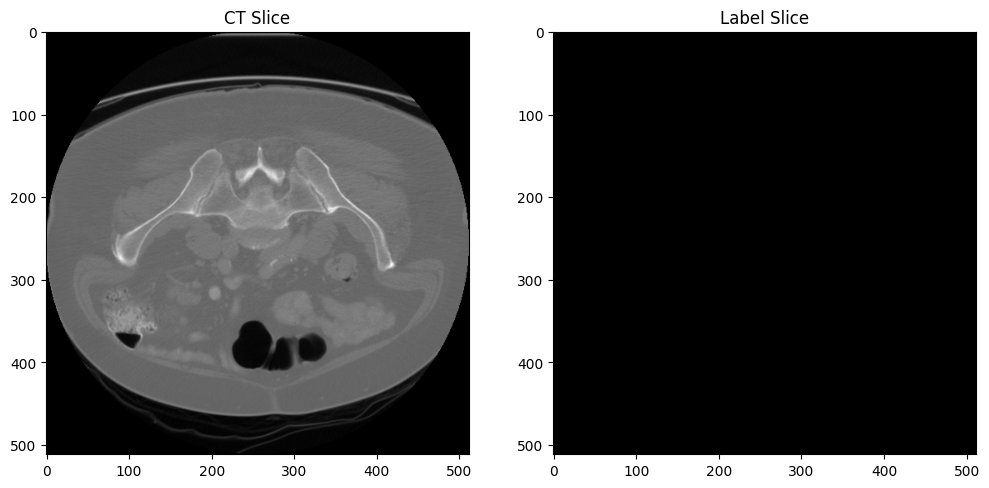

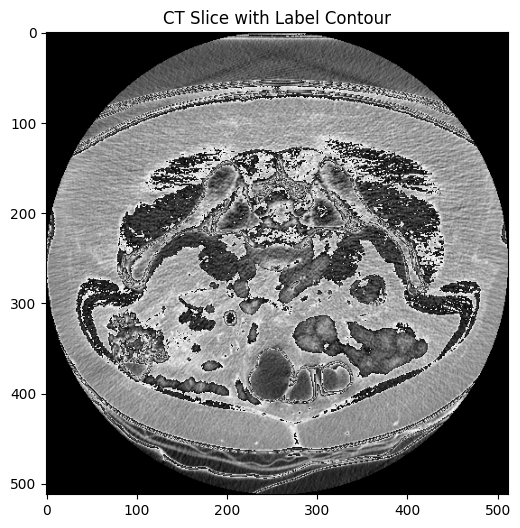

In [12]:
ct_scan = load_ct_scan('Task09_Spleen/imagesTr/spleen_2.nii.gz')
label_image = load_ct_scan('Task09_Spleen/labelsTr/spleen_2.nii.gz')

print("CT scan shape:", ct_scan.shape)
print("Label image shape:", label_image.shape)

slice_index = 35
ct_slice = ct_scan[:, :, slice_index]
label_slice = label_image[:, :, slice_index]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("CT Slice")
plt.imshow(ct_slice, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Label Slice")
plt.imshow(label_slice, cmap='gray')

plt.show()

contours, _ = cv.findContours(label_slice.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
overlay = cv.cvtColor(ct_slice.astype(np.uint8), cv.COLOR_GRAY2BGR)
cv.drawContours(overlay, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(6, 6))
plt.title("CT Slice with Label Contour")
plt.imshow(overlay)
plt.show()

> ### Assignment 2: Measure Spleen Width
> 
> Calculate the **maximum anterior-posterior (AP) width** of the spleen on transverse CT slices. The AP width is the > longest distance between the anterior (front) and posterior (back) parts of the spleen in a given transverse (parallel to the floor when standing) slice.
> 
> This distance corresponds to the top-most voxel to the bottom-most voxel in the spleen region of the label image. The measurement is parallel to the top-bottom axis of the image.
>
> ![Screenshot 2025-01-20 at 10.54.55.png](https://marinbenc.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff636e5c1-42c8-49e7-9cc3-e812a7ed4e8b%2F6564a0f0-77d4-4d77-b1c0-7447eb16e36e%2FScreenshot_2025-01-20_at_10.54.55.png?table=block&id=1814daba-200a-8038-9271-f5d3845d973c&spaceId=f636e5c1-42c8-49e7-9cc3-e812a7ed4e8b&width=490&userId=&cache=v2)

In [13]:
def calculate_ap_width(label_slice):
    spleen_indices = np.where(label_slice == 1)
    
    if len(spleen_indices[0]) == 0:
        return 0
    
    ap_width = np.max(spleen_indices[0]) - np.min(spleen_indices[0])
    
    return ap_width

ap_width = calculate_ap_width(label_slice)
print("Maximum AP width of the spleen in pixels:", ap_width)


Maximum AP width of the spleen in pixels: 0


> ### Assignment 3: Convert Width to Millimeters and Analyze Results
> 
> 1. **Convert to Millimeters:**
>     - Use the voxel spacing information from the metadata of each NIfTI file to convert the measured spleen widths (in > pixels) to millimeters.
>     - You can extract voxel spacing from the affine matrix using the `nibabel.affines.voxel_sizes` function.
>     
>     **Hint:** Refer to [this link](https://nipy.org/nibabel/reference/nibabel.affines.html#nibabel.affines.voxel_sizes) for more details on how to use the affine matrix.
>     
>     Example code to retrieve voxel spacing:
>     
>     ```python
>     nifti_file = nib.load('Task09_Spleen/imagesTr/spleen_13.nii.gz')
>     affine = nifti_file.affine
>     voxel_spacing = nib.affines.voxel_sizes(affine)
>     
>     ```
> 
> 2. **Calculate for Each Patient:**
>     - Iterate through all patient files in the dataset.
>     - For each patient, calculate the **maximum AP width** across all transverse slices.
>     - Convert the maximum width from pixels to millimeters using the voxel spacing.
> 3. **Store Results:**
>     - Create a data structure (e.g., dictionary, table) to store the results in the format:`Patient ID: Maximum Spleen Width (mm)`.
> 4. **Analyze Splenomegaly:**
>     - Use **Radiopaedia** or other references to check spleen max. AP width thresholds for diagnosing splenomegaly.
>     - Based on the results, identify which patients might have splenomegaly.
>     - https://radiopaedia.org/articles/splenomegaly

In [ ]:
import os

def get_voxel_spacing(file):
    nifti_file = nib.load(file)
    affine = nifti_file.affine
    voxel_spacing = nib.affines.voxel_sizes(affine)
    return voxel_spacing

def calculate_max_ap_width(ct_scan, label_image):
    max_ap_width = 0
    for i in range(ct_scan.shape[2]):
        label_slice = label_image[:, :, i]
        ap_width = calculate_ap_width(label_slice)
        if ap_width > max_ap_width:
            max_ap_width = ap_width
    return max_ap_width

def convert_to_mm(width_in_pixels, voxel_spacing):
    return width_in_pixels * voxel_spacing[0]

data_dir = 'Task09_Spleen/imagesTr'
label_dir = 'Task09_Spleen/labelsTr'

results = {}

for file in os.listdir(data_dir):
    if file.endswith('.nii.gz') and not file.startswith('._'):
        patient_id = file.split('.')[0]
        ct_scan = load_ct_scan(os.path.join(data_dir, file))
        label_image = load_ct_scan(os.path.join(label_dir, file.replace('imagesTr', 'labelsTr')))
        
        max_ap_width_pixels = calculate_max_ap_width(ct_scan, label_image)
        voxel_spacing = get_voxel_spacing(os.path.join(data_dir, file))
        max_ap_width_mm = convert_to_mm(max_ap_width_pixels, voxel_spacing)
        
        results[patient_id] = max_ap_width_mm

for patient_id, width_mm in results.items():
    print(f"Patient {patient_id}: Maximum Spleen Width (mm) = {width_mm:.2f}")

splenomegaly_threshold = 120  
patients_with_splenomegaly = [patient_id for patient_id, width_mm in results.items() if width_mm > splenomegaly_threshold]

print("\nPatients with potential splenomegaly:")
for patient_id in patients_with_splenomegaly:
    print(f"Patient {patient_id}: Maximum Spleen Width (mm) = {results[patient_id]:.2f}")

Patient spleen_10: Maximum Spleen Width (mm) = 109.37
Patient spleen_12: Maximum Spleen Width (mm) = 122.13
Patient spleen_13: Maximum Spleen Width (mm) = 104.65
Patient spleen_14: Maximum Spleen Width (mm) = 131.14
Patient spleen_16: Maximum Spleen Width (mm) = 79.30
Patient spleen_17: Maximum Spleen Width (mm) = 46.61
Patient spleen_18: Maximum Spleen Width (mm) = 85.08
Patient spleen_19: Maximum Spleen Width (mm) = 125.11
Patient spleen_2: Maximum Spleen Width (mm) = 97.78
Patient spleen_20: Maximum Spleen Width (mm) = 86.82
Patient spleen_21: Maximum Spleen Width (mm) = 74.11
Patient spleen_22: Maximum Spleen Width (mm) = 98.81
Patient spleen_24: Maximum Spleen Width (mm) = 62.42
Patient spleen_25: Maximum Spleen Width (mm) = 55.34
Patient spleen_26: Maximum Spleen Width (mm) = 78.61
Patient spleen_27: Maximum Spleen Width (mm) = 68.49
Patient spleen_28: Maximum Spleen Width (mm) = 71.25
Patient spleen_29: Maximum Spleen Width (mm) = 77.34
Patient spleen_3: Maximum Spleen Width (mm

Don't forget to save your results to GitHub.